This is some interesting maths...

$\sum{}_{i=1}^{n} i = \frac{n(n+1)}{2}$

In [1]:
#imports
# %matplotlib widget
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display_markdown
import datetime

from numpy import nan
from import_OMNI import read_OMNI, nan_value
from import_ACE import read_ACE
from import_cdaweb import read_CDAWeb
from entropy import H, MI, CMI, entropy_matrix
from storm_selection import findSeq



In [2]:
df = read_OMNI(
    filepath="../OMNI/datasets/test_2.txt",
    formatpath="../OMNI/data_format/test_2_format.txt",
)
print(list(df))


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:39: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


['Datetime', 'Field', 'BX', 'BY', 'BZ', 'BY, (GSM)', 'BZ, (GSM)', 'RMS', 'RMS, nT', 'Speed', 'Vx', 'Vy', 'Vz', 'Proton', 'Proton, K', 'Na/Np', 'Flow', 'Electric', 'Plasma', 'Alfven', 'Magnetosonic', 'AE-index', 'AL-index', 'AU-index', 'SYM/D', 'SYM/H', 'ASY/D', 'ASY/H']


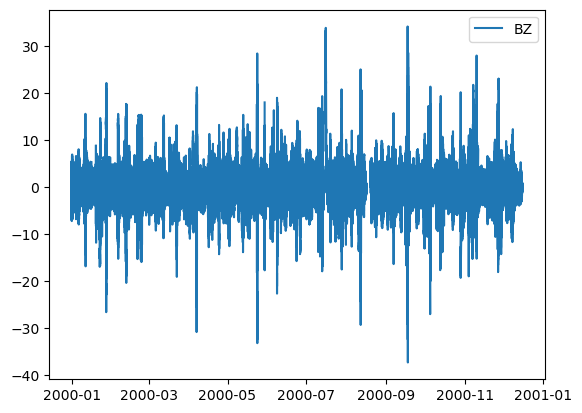

In [3]:
# for column in list(df)[1:]:
    # plt.plot(df["Datetime"], df[column], label=column)
plt.plot(df["Datetime"], df["BZ"], label="BZ")
# plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
# plt.hist(df["SYM/H"], 150)
plt.legend()
plt.show()

In [4]:
def markdown_entropy_matrix(df):
    em = entropy_matrix(df)

    display_markdown(
f'''| |{"|".join(df.columns[1:])}|
{"".join(["|:-"] * len(df.columns))}|
{"\n".join([f"|{column_name}|{"|".join(map(lambda x: "%.2f" % x, em[i]))}|" for i, column_name in enumerate(df.columns[1:])])}
| |{"|".join([str(len(df[column])) for column in df.columns[1:]])}|
''',
    raw = True
    )

In [5]:
markdown_entropy_matrix(df)

| |Field|BX|BY|BZ|BY, (GSM)|BZ, (GSM)|RMS|RMS, nT|Speed|Vx|Vy|Vz|Proton|Proton, K|Na/Np|Flow|Electric|Plasma|Alfven|Magnetosonic|AE-index|AL-index|AU-index|SYM/D|SYM/H|ASY/D|ASY/H|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|Field|5.57|0.48|0.78|0.47|0.72|0.51|0.03|0.05|0.19|0.18|0.11|0.08|0.22|0.07|-0.13|0.28|0.40|0.17|0.60|0.49|0.08|0.00|-0.49|0.08|0.11|-0.54|0.19|
|BX|0.48|5.88|0.29|0.09|0.27|0.10|0.02|0.03|0.14|0.14|0.10|0.06|0.10|0.07|-0.21|0.13|0.10|0.05|0.17|0.17|-0.02|-0.07|-0.59|0.04|-0.01|-0.64|0.06|
|BY|0.78|0.29|5.95|0.10|2.16|0.13|0.02|0.04|0.13|0.13|0.14|0.05|0.11|0.03|-0.20|0.15|0.11|0.04|0.23|0.23|0.03|-0.04|-0.54|0.06|0.04|-0.60|0.11|
|BZ|0.47|0.09|0.10|5.52|0.11|1.51|0.02|0.02|0.12|0.11|0.07|0.10|0.13|0.04|0.02|0.15|1.36|0.02|0.11|0.12|0.17|0.10|-0.43|0.07|0.06|-0.58|0.15|
|BY, (GSM)|0.72|0.27|2.16|0.11|5.93|0.10|0.02|0.04|0.12|0.12|0.13|0.04|0.12|0.03|-0.03|0.15|0.09|0.03|0.20|0.21|0.02|-0.04|-0.54|0.05|0.02|-0.61|0.10|
|BZ, (GSM)|0.51|0.10|0.13|1.51|0.10|5.61|0.02|0.03|0.12|0.12|0.07|0.09|0.11|0.04|-0.03|0.14|2.99|0.02|0.14|0.15|0.26|0.17|-0.36|0.07|0.09|-0.55|0.20|
|RMS|0.03|0.02|0.02|0.02|0.02|0.02|1.82|0.34|-0.04|-0.04|-0.04|-0.05|-0.00|-0.03|-0.23|0.01|-0.05|-0.05|-0.04|-0.05|-0.05|-0.10|-0.61|0.01|-0.10|-0.69|0.02|
|RMS, nT|0.05|0.03|0.04|0.02|0.04|0.03|0.34|3.82|-0.12|-0.13|-0.14|-0.15|-0.15|-0.09|-0.76|-0.12|-0.15|-0.18|-0.17|-0.16|-0.04|-0.09|-0.61|0.02|-0.10|-0.68|0.02|
|Speed|0.19|0.14|0.13|0.12|0.12|0.12|-0.04|-0.12|6.66|5.46|0.18|0.14|0.30|0.39|0.26|0.15|0.18|0.06|0.10|0.22|0.06|0.01|-0.52|0.08|0.15|-0.58|0.13|
|Vx|0.18|0.14|0.13|0.11|0.12|0.12|-0.04|-0.13|5.46|6.64|0.17|0.13|0.30|0.38|0.23|0.15|0.18|0.06|0.10|0.22|0.06|0.01|-0.52|0.08|0.15|-0.58|0.13|
|Vy|0.11|0.10|0.14|0.07|0.13|0.07|-0.04|-0.14|0.18|0.17|5.45|0.07|0.07|0.16|-0.30|0.08|0.09|0.02|0.05|0.07|-0.03|-0.07|-0.59|0.03|-0.06|-0.66|0.04|
|Vz|0.08|0.06|0.05|0.10|0.04|0.09|-0.05|-0.15|0.14|0.13|0.07|5.35|0.06|0.08|-0.75|0.06|0.12|0.02|0.04|0.05|-0.03|-0.07|-0.60|0.03|-0.07|-0.67|0.03|
|Proton|0.22|0.10|0.11|0.13|0.12|0.11|-0.00|-0.15|0.30|0.30|0.07|0.06|5.21|0.10|0.17|0.87|0.09|0.08|0.13|0.14|-0.01|-0.06|-0.57|0.06|0.08|-0.64|0.06|
|Proton, K|0.07|0.07|0.03|0.04|0.03|0.04|-0.03|-0.09|0.39|0.38|0.16|0.08|0.10|3.01|-0.85|0.07|0.06|0.02|0.05|0.06|-0.02|-0.07|-0.59|0.02|-0.06|-0.67|0.04|
|Na/Np|-0.13|-0.21|-0.20|0.02|-0.03|-0.03|-0.23|-0.76|0.26|0.23|-0.30|-0.75|0.17|-0.85|4.97|-0.00|-0.25|-0.40|-0.41|0.36|-0.37|-0.09|-0.78|0.30|-0.39|-0.63|-1.24|
|Flow|0.28|0.13|0.15|0.15|0.15|0.14|0.01|-0.12|0.15|0.15|0.08|0.06|0.87|0.07|-0.00|4.49|0.16|0.04|0.18|0.21|0.03|-0.03|-0.51|0.07|0.01|-0.61|0.11|
|Electric|0.40|0.10|0.11|1.36|0.09|2.99|-0.05|-0.15|0.18|0.18|0.09|0.12|0.09|0.06|-0.25|0.16|4.85|0.04|0.12|0.12|0.28|0.20|-0.35|0.07|0.09|-0.53|0.22|
|Plasma|0.17|0.05|0.04|0.02|0.03|0.02|-0.05|-0.18|0.06|0.06|0.02|0.02|0.08|0.02|-0.40|0.04|0.04|0.67|0.40|0.12|-0.06|-0.10|-0.63|0.00|-0.11|-0.70|-0.01|
|Alfven|0.60|0.17|0.23|0.11|0.20|0.14|-0.04|-0.17|0.10|0.10|0.05|0.04|0.13|0.05|-0.41|0.18|0.12|0.40|3.81|1.64|-0.04|-0.08|-0.61|0.02|-0.04|-0.66|0.03|
|Magnetosonic|0.49|0.17|0.23|0.12|0.21|0.15|-0.05|-0.16|0.22|0.22|0.07|0.05|0.14|0.06|0.36|0.21|0.12|0.12|1.64|5.67|-0.02|-0.07|-0.59|0.04|-0.02|-0.65|0.05|
|AE-index|0.08|-0.02|0.03|0.17|0.02|0.26|-0.05|-0.04|0.06|0.06|-0.03|-0.03|-0.01|-0.02|-0.37|0.03|0.28|-0.06|-0.04|-0.02|5.19|1.70|1.14|0.08|0.26|0.23|0.36|
|AL-index|0.00|-0.07|-0.04|0.10|-0.04|0.17|-0.10|-0.09|0.01|0.01|-0.07|-0.07|-0.06|-0.07|-0.09|-0.03|0.20|-0.10|-0.08|-0.07|1.70|4.71|0.53|0.08|0.26|0.21|0.34|
|AU-index|-0.49|-0.59|-0.54|-0.43|-0.54|-0.36|-0.61|-0.61|-0.52|-0.52|-0.59|-0.60|-0.57|-0.59|-0.78|-0.51|-0.35|-0.63|-0.61|-0.59|1.14|0.53|4.39|0.07|0.20|0.18|0.26|
|SYM/D|0.08|0.04|0.06|0.07|0.05|0.07|0.01|0.02|0.08|0.08|0.03|0.03|0.06|0.02|0.30|0.07|0.07|0.00|0.02|0.04|0.08|0.08|0.07|3.82|0.14|0.12|0.10|
|SYM/H|0.11|-0.01|0.04|0.06|0.02|0.09|-0.10|-0.10|0.15|0.15|-0.06|-0.07|0.08|-0.06|-0.39|0.01|0.09|-0.11|-0.04|-0.02|0.26|0.26|0.20|0.14|5.31|0.27|0.37|
|ASY/D|-0.54|-0.64|-0.60|-0.58|-0.61|-0.55|-0.69|-0.68|-0.58|-0.58|-0.66|-0.67|-0.64|-0.67|-0.63|-0.61|-0.53|-0.70|-0.66|-0.65|0.23|0.21|0.18|0.12|0.27|4.49|0.29|
|ASY/H|0.19|0.06|0.11|0.15|0.10|0.20|0.02|0.02|0.13|0.13|0.04|0.03|0.06|0.04|-1.24|0.11|0.22|-0.01|0.03|0.05|0.36|0.34|0.26|0.10|0.37|0.29|4.10|
| |503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|503908|


In [6]:
inds, ranges=findSeq(-df["SYM/H"],20,100,6*60, return_ranges=True)
# plt.plot(df["Datetime"], df["SYM/H, nT"])


Min / max thresholds are: 20.00 , 100.00
15 sequences found.
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).


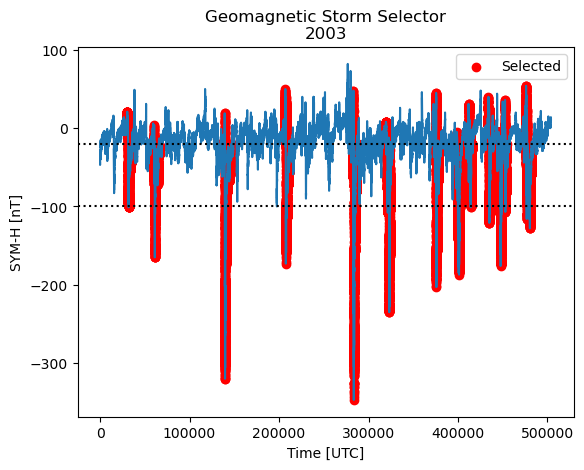

In [7]:
plt.figure()
plt.plot(df["SYM/H"])
plt.scatter(df["Datetime"].iloc[inds].index,df["SYM/H"].iloc[inds],color='r',label='Selected')
plt.axhline(-20,color='k',linestyle=':')
plt.axhline(-100,color='k',linestyle=':')
plt.title('Geomagnetic Storm Selector\n2003')
plt.xlabel('Time [UTC]')
plt.ylabel('SYM-H [nT]')

plt.legend()
plt.show()

In [8]:
storm_entropies = [H(df["SYM/H"].iloc[range(storm[0], storm[1])]) for storm in ranges]

print(f"Nominal SYM/H entropy: {H(df["SYM/H"])}")
print(f"Storm SYM/H entropies: {storm_entropies} \nAverage storm entropy (per storm): {sum(storm_entropies)/len(storm_entropies)}")
print(f"Storm entropies calculated taking storms as a set of datapoints: {H(df["SYM/H"].iloc[inds])}")
# we can initially discern a large increase in information describing SYM/H

Nominal SYM/H entropy: 5.312488293617374
Storm SYM/H entropies: [6.212106944881131, 6.3425537416489775, 5.9143392309094, 6.688358153140376, 6.452986381554365, 6.763289217993692, 6.944527311953678, 6.924064236060779, 6.493469653778293, 6.410410009295125, 6.793241997978076, 6.373514930328498, 6.790725228277255] 
Average storm entropy (per storm): 6.546429772138434
Storm entropies calculated taking storms as a set of datapoints: 6.354118491416385


In [9]:
# evaluating average entropies of all stats in a storm
stormy_H = np.array([H(df[column].iloc[inds]) for column in list(df)[1:]])

nominal_H =  np.array([H(df[column]) for column in list(df)[1:]])

stormy_H - nominal_H

array([0.76790457, 0.29232702, 0.48792675, 0.68575441, 0.47022722,
       0.70515938, 0.15669434, 0.10485973, 0.28993548, 0.30935875,
       0.47711163, 0.3093075 , 0.68518968, 1.38345761, 0.87693524,
       0.78413224, 0.90925794, 0.48715695, 0.50592825, 0.34020332,
       0.67676698, 0.792335  , 0.54800053, 0.52003964, 1.0416302 ,
       0.69202269, 0.8958106 ])

In [10]:
def find_bin_num(func, default = 100):
    bin_num = default
    while not np.isclose(func(bin_num), func(bin_num-50)):
        bin_num += 100
    return bin_num


In [11]:
def gradient_desc(f, initial = 100, step_size = 100, weight = 1):
    x = initial
    grad = f(x+step_size) - f(x)
    while not np.isclose(grad,0):
        print(x, grad)
        x += int(grad*step_size*weight)
        grad = f(x+step_size) - f(x)
        
    return x+step_size
   

In [12]:
# [find_bin_num(lambda x: H(df[column], bins=x)) for column in list(df)[1:]]

In [13]:
df2 = read_ACE("../ACE/ACE_Browse_Data.txt")
df2.columns

Index(['ACE_epoch_time', 'B_rtn_r_MAG', 'B_rtn_t_MAG', 'B_rtn_n_MAG',
       'B_rtn_theta_MAG', 'B_rtn_phi_MAG', 'B_gse_x_MAG', 'B_gse_y_MAG',
       'B_gse_z_MAG', 'B_gse_theta_MAG', 'B_gse_phi_MAG', 'B_gsm_x_MAG',
       'B_gsm_y_MAG', 'B_gsm_z_MAG', 'B_gsm_theta_MAG', 'B_gsm_phi_MAG',
       'B_magnitude_MAG'],
      dtype='object')

In [14]:
markdown_entropy_matrix(df2)

| |B_rtn_r_MAG|B_rtn_t_MAG|B_rtn_n_MAG|B_rtn_theta_MAG|B_rtn_phi_MAG|B_gse_x_MAG|B_gse_y_MAG|B_gse_z_MAG|B_gse_theta_MAG|B_gse_phi_MAG|B_gsm_x_MAG|B_gsm_y_MAG|B_gsm_z_MAG|B_gsm_theta_MAG|B_gsm_phi_MAG|B_magnitude_MAG|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|B_rtn_r_MAG|6.25|0.29|0.15|0.25|1.81|6.05|0.29|0.15|0.26|1.80|6.05|0.28|0.14|0.27|1.79|0.50|
|B_rtn_t_MAG|0.29|5.88|0.18|0.25|1.92|0.29|3.80|0.18|0.24|1.80|0.29|2.12|0.18|0.19|1.37|0.75|
|B_rtn_n_MAG|0.15|0.18|5.59|2.32|0.19|0.15|0.17|3.17|1.97|0.18|0.15|0.18|1.48|1.15|0.19|0.49|
|B_rtn_theta_MAG|0.25|0.25|2.32|7.24|0.31|0.25|0.24|1.96|3.28|0.31|0.25|0.20|1.11|1.43|0.32|0.18|
|B_rtn_phi_MAG|1.81|1.92|0.19|0.31|7.53|1.81|1.79|0.18|0.31|5.16|1.81|1.35|0.18|0.33|3.52|0.23|
|B_gse_x_MAG|6.05|0.29|0.15|0.25|1.81|6.25|0.29|0.15|0.26|1.80|6.25|0.28|0.14|0.27|1.79|0.50|
|B_gse_y_MAG|0.29|3.80|0.17|0.24|1.79|0.29|5.86|0.17|0.25|1.91|0.29|2.23|0.17|0.19|1.40|0.74|
|B_gse_z_MAG|0.15|0.18|3.17|1.96|0.18|0.15|0.17|5.54|2.32|0.18|0.15|0.17|1.60|1.22|0.18|0.49|
|B_gse_theta_MAG|0.26|0.24|1.97|3.28|0.31|0.26|0.25|2.32|7.24|0.31|0.26|0.20|1.19|1.55|0.32|0.19|
|B_gse_phi_MAG|1.80|1.80|0.18|0.31|5.16|1.80|1.91|0.18|0.31|7.53|1.80|1.39|0.18|0.32|3.64|0.23|
|B_gsm_x_MAG|6.05|0.29|0.15|0.25|1.81|6.25|0.29|0.15|0.26|1.80|6.25|0.28|0.14|0.27|1.79|0.50|
|B_gsm_y_MAG|0.28|2.12|0.18|0.20|1.35|0.28|2.23|0.17|0.20|1.39|0.28|5.80|0.15|0.25|1.91|0.70|
|B_gsm_z_MAG|0.14|0.18|1.48|1.11|0.18|0.14|0.17|1.60|1.19|0.18|0.14|0.15|5.36|2.28|0.17|0.50|
|B_gsm_theta_MAG|0.27|0.19|1.15|1.43|0.33|0.27|0.19|1.22|1.55|0.32|0.27|0.25|2.28|7.29|0.32|0.19|
|B_gsm_phi_MAG|1.79|1.37|0.19|0.32|3.52|1.79|1.40|0.18|0.32|3.64|1.79|1.91|0.17|0.32|7.54|0.22|
|B_magnitude_MAG|0.50|0.75|0.49|0.18|0.23|0.50|0.74|0.49|0.19|0.23|0.50|0.70|0.50|0.19|0.22|5.55|
| |105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|


In [15]:
read_CDAWeb("../CDAWeb/ac_h3s_mfi_20210101000000_20210131235959.cdf", "../CDAWeb/ac_h0s_swe_20210101000054_20210131235945.cdf")

(                          Epoch  Bx (GSM)  By (GSM)  Bz (GSM)
 0       2021-01-01 00:00:00.700     0.365    -2.808     1.083
 1       2021-01-01 00:00:01.700     0.359    -2.813     1.111
 2       2021-01-01 00:00:02.700     0.330    -2.799     1.094
 3       2021-01-01 00:00:03.700     0.331    -2.769     1.060
 4       2021-01-01 00:00:04.700     0.260    -2.750     0.992
 ...                         ...       ...       ...       ...
 2678400 2021-01-31 23:59:55.335     3.530     0.334    -2.530
 2678401 2021-01-31 23:59:56.343     3.545     0.317    -2.537
 2678402 2021-01-31 23:59:57.335     3.423     0.307    -2.540
 2678403 2021-01-31 23:59:58.343     3.281     0.323    -2.556
 2678404 2021-01-31 23:59:59.343     3.393     0.345    -2.532
 
 [2678405 rows x 4 columns],
                     Epoch       Np            Vp           Tpr
 0     2021-01-01 00:00:54   4.2446  3.624100e+02  17858.699219
 1     2021-01-01 00:01:58   4.2183  3.651400e+02  16402.900391
 2     2021-01-01 00: